# Auditory cortex working model 

## Localization and parcellation of the auditory cortex 

As mentioned before, we are interested in the functional principles of the [human auditory cortex](https://en.wikipedia.org/wiki/Auditory_cortex) and thus want to restrict our analyses to the corresponding region. [The question of choosing the "right" atlas is not an easy one and is actively discussed throughout neuroimaging](). The auditory cortex is no exception to that, to the contrary: [it's localization and parcellation is even less standardized and agreed on than other primary sensory regions]() (e.g. visual and motor cortex). As the corresponding discussion is, even though tremendously important, unfortunately outside the scope of our project, we thus decided to choose an atlas that first, allows the investigation of the proposed functional principles and second, is a trade off between a parsimonious and fine-grained subregion solution. Given these factors, we utilized the [Harvard-Oxford-Atlas](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases) within our project. 
It includes aspects of the auditory cortex, per hemisphere, primary and non-primary regions, within Superior Temporal Plane (STP) and Superior Temporal Gyrus (STG), as well as regions in the anterior and posterior direction. In more detail, we're going to gather the following ROIs:

[Heschl gyrus (HG)](https://en.wikipedia.org/wiki/Transverse_temporal_gyrus)  
[Planum Polare (PP)](http://braininfo.rprc.washington.edu/centraldirectory.aspx?ID=2020)  
[Planum Temporale (PT)](https://en.wikipedia.org/wiki/Planum_temporale)  
[anterior Superior Temporal Gyrus (aSTG)](https://en.wikipedia.org/wiki/Superior_temporal_gyrus)  
[posterior Superior Temporal Gyrus (pSTG)](https://en.wikipedia.org/wiki/Superior_temporal_gyrus)  

The obtained ROIs will be used in complementary approaches in MVPA and connectivity analyses. Each ROI will be utilized separately within [ROI decoding analyses]() to investigate if the voxel reponses within a certain region allow the distinction between the different sound categories, that is if they contain information about them. Additionally, they will be used to investigate category induced changes in [functional connectivity](), that is if the functional connectivity between ROIs varies as a function of sound category. The ROIs will be combined to create a mask we will restrict the [searchlight analyses]() to through which we aim to unravel where in the auditory cortex information regarding the categories is present. Furthermore, the mask will be employed for [voxel-by-voxel functional connectivity and gradient embedding]() to evaluate what regions of the auditory cortex express comparable temporal response profile patterns over time.

Hereinafter, you can see and, if you want, redo the respective steps we conducted to obtained the ROIs and mask. 
We'll use [nipype](https://nipype.readthedocs.io/en/latest/) & [nilearn](http://nilearn.github.io/) functionality to conduct them.     
 

## Import necessary modules and functions



In [ ]:
import os
from os.path import join as opj
import nibabel as nb
from nilearn import datasets
from nilearn.image import math_img
from nilearn.plotting import plot_anat
from nipype.pipeline import Node
from nipype.algorithms.misc import PickAtlas
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors
import seaborn as sns

%matplotlib inline

## Obtain the atlas and extract ROIs

At first, we'll download the Harvard-Oxford atlas using `nilearn`:


In [ ]:
dataset_harvard_oxford = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename_harvard_oxford = dataset_harvard_oxford.maps

To extract our ROIs, we need to know their name, label and/or number in the given parcellation. Let's find that out: 


In [ ]:
for labels_harvard_oxford in enumerate(dataset_harvard_oxford.labels):
    print(labels_harvard_oxford)

(0, 'Background')
(1, 'Frontal Pole')
(2, 'Insular Cortex')
(3, 'Superior Frontal Gyrus')
(4, 'Middle Frontal Gyrus')
(5, 'Inferior Frontal Gyrus, pars triangularis')
(6, 'Inferior Frontal Gyrus, pars opercularis')
(7, 'Precentral Gyrus')
(8, 'Temporal Pole')
(9, 'Superior Temporal Gyrus, anterior division')
(10, 'Superior Temporal Gyrus, posterior division')
(11, 'Middle Temporal Gyrus, anterior division')
(12, 'Middle Temporal Gyrus, posterior division')
(13, 'Middle Temporal Gyrus, temporooccipital part')
(14, 'Inferior Temporal Gyrus, anterior division')
(15, 'Inferior Temporal Gyrus, posterior division')
(16, 'Inferior Temporal Gyrus, temporooccipital part')
(17, 'Postcentral Gyrus')
(18, 'Superior Parietal Lobule')
(19, 'Supramarginal Gyrus, anterior division')
(20, 'Supramarginal Gyrus, posterior division')
(21, 'Angular Gyrus')
(22, 'Lateral Occipital Cortex, superior division')
(23, 'Lateral Occipital Cortex, inferior division')
(24, 'Intracalcarine Cortex')
(25, 'Frontal Medi

As we can see, the regions we are interest in have the following labels:

HG - 45  
PP - 44  
PT - 46  
aSTG - 9  
pSTG - 10  

While other atlases distinguish hemispheres on the label level, the one we're using does not. Therefore, we need to specify the hemisphere in the function that extracts the ROIs from the atlas. For this, we'll employ [nipype's PickAtlas() function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.misc.html#pickatlas). As we want to extract multiple ROIs from the same atlas, we'll set up a general ROI extraction node, defining only the input atlas and create clone nodes for each ROI respectively. Here's the setup for the general ROI extraction node: 


In [ ]:
extract_ROIs_harvard_oxford = Node(PickAtlas(), name='extract_ROIs_harvard_oxford')
extract_ROIs_harvard_oxford.inputs.atlas = atlas_filename_harvard_oxford


If we, for example, want to extract the left hemisphere HG, the ROI specific cloned node would look as follows:  


In [ ]:
## setup ROI specific node - HG left
extract_ROIs_harvard_oxford_HG_left = extract_ROIs_harvard_oxford.clone(name='extract_ROIs_harvard_oxford_HG_left')
extract_ROIs_harvard_oxford_HG_left.inputs.hemi = 'left'
extract_ROIs_harvard_oxford_HG_left.inputs.labels = 45
extract_ROIs_harvard_oxford_HG_left.inputs.output_file = '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-HGleft_mask.nii.gz'

## run node
extract_ROIs_harvard_oxford_HG_left.run()

## check if ROIs was extracted and saved
os.listdir('/data/mvs/derivatives/ROIs_masks/')

['tpl-MNI152NLin6Sym_res_02_desc-HGleft_mask.nii.gz']

Great, that seems to work. Now let's extract the remaining ROIs. As we're lazy, we're going to do this within a small for-loop instead of running it one by one manually:


In [ ]:
roi_name_tpl = '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-'

for hemi in ['left', 'right']:
    for label, name in zip([45,44,46,9,10], ['HG', 'PP', 'PT', 'aSTG', 'pSTG']):
        print('extracting ROI %s with label %s from %s hemisphere' %(name, label, hemi))
       
        ##set up node
        extract_ROIs_harvard_oxford_tmp = extract_ROIs_harvard_oxford.clone(name='extract_ROIs_harvard_oxford_tmp')
        extract_ROIs_harvard_oxford_tmp.inputs.hemi = hemi
        extract_ROIs_harvard_oxford_tmp.inputs.labels = label
        extract_ROIs_harvard_oxford_tmp.inputs.output_file = '%s%s%s_mask.nii.gz' %(roi_name_tpl, name, hemi)

        ## run node
        extract_ROIs_harvard_oxford_tmp.run()
        
        del extract_ROIs_harvard_oxford_tmp
        
## check if ROIs was extracted and saved
os.listdir('/data/mvs/derivatives/ROIs_masks/')

['tpl-MNI152NLin6Sym_res_02_desc-aSTGleft_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-aSTGright_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-pSTGright_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-ACdilated_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-HGright_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-PPleft_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-HGleft_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-pSTGleft_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-ACleft_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-ACright_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-AC_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-PTright_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-PTleft_mask.nii.gz',
 'tpl-MNI152NLin6Sym_res_02_desc-PPright_mask.nii.gz']

Having extracted all the ROIs we wanted to include, we can now also combine into a new file which will be the mask we're going to use in the planned searchlight analyses. To do so, we're going to use `nilearn` again, more precisely it's `math_img` functionality.

## Merge ROIs to create an auditory cortex mask

At first, we define the path to the ROIs:

In [ ]:
ROI_path = '/data/mvs/derivatives/ROIs_masks/'


Next, we load all ROIs:

In [ ]:
HG_left = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-HGleft_mask.nii.gz'))
HG_right = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-HGright_mask.nii.gz'))
PP_left = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-PPleft_mask.nii.gz'))
PP_right = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-PPright_mask.nii.gz'))
PT_left = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-PTleft_mask.nii.gz'))
PT_right = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-PTright_mask.nii.gz'))
aSTG_left = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-aSTGleft_mask.nii.gz'))
aSTG_right = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-aSTGright_mask.nii.gz'))
pSTG_left = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-pSTGleft_mask.nii.gz'))
pSTG_right = nb.load(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-pSTGright_mask.nii.gz'))


Now we can combine them into one mask:

In [ ]:
ac_mask = math_img("HG_left+HG_right+PP_left+PP_right+PT_left+PT_right+aSTG_left+aSTG_right+pSTG_left+pSTG_right",
                           HG_left=HG_left, PP_left=PP_left, PT_left=PT_left, aSTG_left=aSTG_left, pSTG_left=pSTG_left,
                           HG_right=HG_right, PP_right=PP_right, PT_right=PT_right, aSTG_right=aSTG_right, pSTG_right=pSTG_right,)

ac_mask.to_filename(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-AC_mask.nii.gz'))

As we know that there will be some hemisphere specific analyses along our way, we'll also create an auditory cortex mask for a given hemisphere. First, the left hemisphere:

In [ ]:
ac_mask_left = math_img("HG_left+PP_left+PT_left+aSTG_left+pSTG_left",
                         HG_left=HG_left, PP_left=PP_left, PT_left=PT_left, aSTG_left=aSTG_left, pSTG_left=pSTG_left)

ac_mask_left.to_filename(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-ACleft_mask.nii.gz'))

And for the right hemisphere:

In [ ]:
ac_mask_right = math_img("HG_right+PP_right+PT_right+aSTG_right+pSTG_right",
                          HG_right=HG_right, PP_right=PP_right, PT_right=PT_right, aSTG_right=aSTG_right, pSTG_right=pSTG_right,)

ac_mask_right.to_filename(opj(ROI_path, 'tpl-MNI152NLin6Sym_res_02_desc-ACright_mask.nii.gz'))

Before we brashly assume that everything worked out, it would be a good idea to visually check our ROIs and auditory cortex mask to make sure nothing is off. Once more, we're lucky that nilearn exists, as it also comes with a lot of [plotting functionalities](http://nilearn.github.io/plotting/index.html#plotting):

## Evaluating ROIs and auditory cortex mask:

In order to get a nice overview, we'll plot the ROIs in within the left hemisphere and the auditory cortex mask within the right:

Text(-215, 90, 'Auditory cortex ROIs')

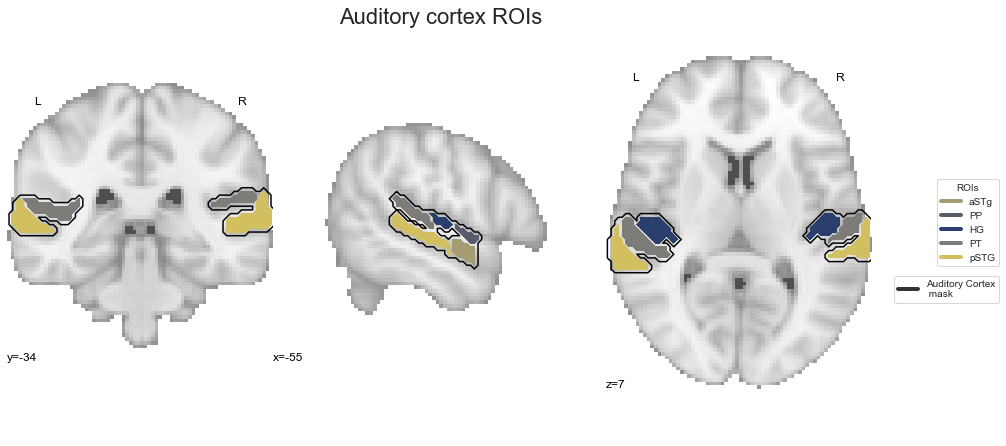

In [ ]:
#suppress contour related warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')
plt.rcParams["font.family"] = "Arial"   

fig=plt.figure(num=None, figsize=(12, 6))
check_ROIs = plot_anat(cut_coords=[-55, -34, 7], figure=fig, draw_cross=False)
check_ROIs.add_contours(HG_left, 
                        colors=[sns.color_palette('cividis', 5)[0]],
                        filled=True)
check_ROIs.add_contours(PP_left, 
                        colors=[sns.color_palette('cividis', 5)[1]],
                        filled=True)
check_ROIs.add_contours(PT_left, 
                        colors=[sns.color_palette('cividis', 5)[2]],
                        filled=True)
check_ROIs.add_contours(aSTG_left, 
                        colors=[sns.color_palette('cividis', 5)[3]],
                        filled=True)
check_ROIs.add_contours(pSTG_left, 
                        colors=[sns.color_palette('cividis', 5)[4]],
                        filled=True)

check_ROIs.add_contours(HG_right, 
                        colors=[sns.color_palette('cividis', 5)[0]],
                        filled=True)
check_ROIs.add_contours(PP_right, 
                        colors=[sns.color_palette('cividis', 5)[1]],
                        filled=True)
check_ROIs.add_contours(PT_right, 
                        colors=[sns.color_palette('cividis', 5)[2]],
                        filled=True)
check_ROIs.add_contours(aSTG_right, 
                        colors=[sns.color_palette('cividis', 5)[3]],
                        filled=True)
check_ROIs.add_contours(pSTG_right, 
                        colors=[sns.color_palette('cividis', 5)[4]],
                        filled=True)
check_ROIs.add_contours(ac_mask, 
                        levels=[0], colors='black')

mask_legend = [Line2D([0], [0], color='black', lw=4, label='Auditory Cortex\n mask', alpha=0.8)]
first_legend = plt.legend(handles=mask_legend, bbox_to_anchor=(1.5,0.3), loc='right')
plt.gca().add_artist(first_legend)

roi_legend = [Line2D([0], [0], color=sns.color_palette('cividis', 5)[3], lw=4, label='aSTg'),
              Line2D([0], [0], color=sns.color_palette('cividis', 5)[1], lw=4, label='PP'), 
              Line2D([0], [0], color=sns.color_palette('cividis', 5)[0], lw=4, label='HG'), 
              Line2D([0], [0], color=sns.color_palette('cividis', 5)[2], lw=4, label='PT'),
              Line2D([0], [0], color=sns.color_palette('cividis', 5)[4], lw=4, label='pSTG')]
plt.legend(handles=roi_legend, bbox_to_anchor=(1.5,0.5), loc="right", title='ROIs')

plt.text(-215, 90, 'Auditory cortex ROIs',
         fontsize=22)

That looks about right! Now, we can start with the planned analyses, beginning with the `MVPA`.

### Access the ROIs and masks
Instead of rerunning the steps above and/or if you just want the `ROI`s and the `masks`, you can access these files in the form we used them in [this section of the project's OSF project]().